## ARIMA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [7]:
df = pd.read_csv("data/Electric_Production.csv", parse_dates=['DATE'], index_col='DATE')

- parse_dates tells pandas to parse this data as datetime objects
- index_col sets DATE as the index (makes slicing easier)

In [8]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


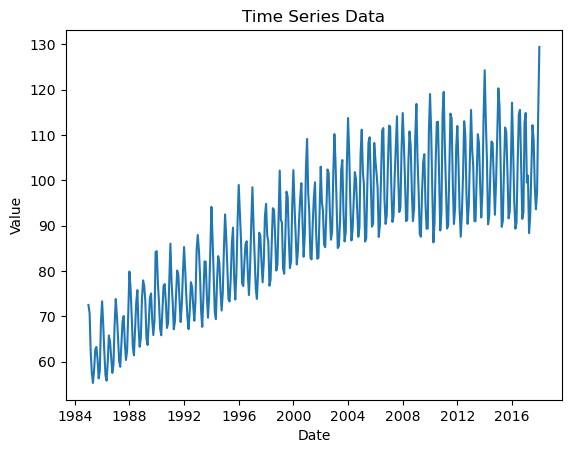

In [10]:
# See an overall pattern - can make this interactive with seaborn or shiny with R
plt.plot(df)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

Checking for stationarity (ARIMA needs it) using ADF/KPSS test, if not we can use differencing/transformation

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['IPG2211A2N'])
print('ADF Statistic:', result[0])
print("Significance Value:", 0.05)
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

#Since p-value>significance value, this data is non-stationary

ADF Statistic: -2.2728852719908756
Significance Value: 0.05
p-value: 0.18086216737344452
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Applying first order differencing and re-calculating

In [14]:
df['IPG2211A2N_FOD'] = df['IPG2211A2N'].diff()

In [15]:
df.head()

,IPG2211A2N,IPG2211A2N_FOD
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563


In [16]:
df.drop(index=df.index[0], axis=0, inplace=True)

In [17]:
df.head()

,IPG2211A2N,IPG2211A2N_FOD
DATE,,
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563
1985-06-01,58.0904,2.7753


In [20]:
result = adfuller(df['IPG2211A2N_FOD'])
print('ADF Statistic:', result[0])
print("Significance Value:", 0.05)
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#Since p-value<significance value, this data is stationary (means are more or less the same)

ADF Statistic: -7.104890882267299
Significance Value: 0.05
p-value: 4.0777865655397073e-10
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
